*A live version of this Jupyter R notebook can be downloaded from http://cs.jhu.edu/~jason/tutorials/GMM-optimization.ipynb*.

# Dynamics of optimizing Gaussian mixture models


This super-simple example illustrates how a Gaussian mixture model behaves with high and low fixed variance (that is, how it collapses or specializes the clusters as in deterministic annealing).

We then examine what happens when we try to _optimize_ the variance together with the means. 

* **Good news:** It's optimal to _specialize_ into low-variance clusters, as expected, and EM or gradient descent will eventually discover this. 

* **Bad news:** Many optimization algorithms are attracted into the neighborhood of a bad saddle point.  They then spend most of their time hanging out there before eventually finding the right solution.  Or worse, they stop numerically near the saddle point before they get to the right solution.

  This bad saddle point is a symmetric solution with high variance.  The clusters _collapse_ into a single cluster whose variance matches the sample variance.  

* **Recommendation:** Thus, rather than using the gradient to optimize the variance, it really is a good idea to sweep through different variance values as an outer loop around the optimizer.  This actively pushes the system away from the saddle point.

  Deterministic annealing (DA) does this.  Often DA is sold as a way to (hopefully) escape bad local optima in latent-variable models.  But it may also be useful in general for escaping the saddle points of such models, which may not be terminal points for optimization but can greatly slow it down.  This super-simple example has no bad local optima, just saddle points.

# Model and log-likelihood function
Throughout the investigation, our model is an equal mixture of two univariate Gaussians with 
symmetric means $\mu,-\mu$  and common variance $\sigma^2$ with $\sigma > 0$. The log-density of the mixture is

In [1]:
# addition in the log domain to avoid underflow.
# This version can add two vectors in parallel.
logadd <- function (a,b) { ifelse(a==-Inf, b,   # The ifelse test avoids the problem that -Inf minus -Inf  NaN.
                                  pmax(a,b) + log1p(exp(pmin(a,b)-pmax(a,b)))) }  

In [2]:
# mixture of univariate Gaussians
ldmix <- function (x,mu,sigma) {
    sigma <- pmax(0,sigma)   # since an unbounded optimizer might explore sigma < 0, just treat that like 0
    # Loses precision:
    # log((dnorm(x,mu,pmax(0,sigma))+dnorm(x,-mu,pmax(0,sigma)))/2)
    logadd( dnorm(x,mu,sigma,log=T) , dnorm(x,-mu,sigma,log=T) ) - log(2)
}

We'll also assume that the only observed datapoints are at 1 and -1.  Then the log-likelihood is

In [3]:
ll <- function (mu,sigma) ldmix(1,mu,sigma)+ldmix(-1,mu,sigma)

<a name="ll-surface"></a>
Let's visualize that log-likelihood function:

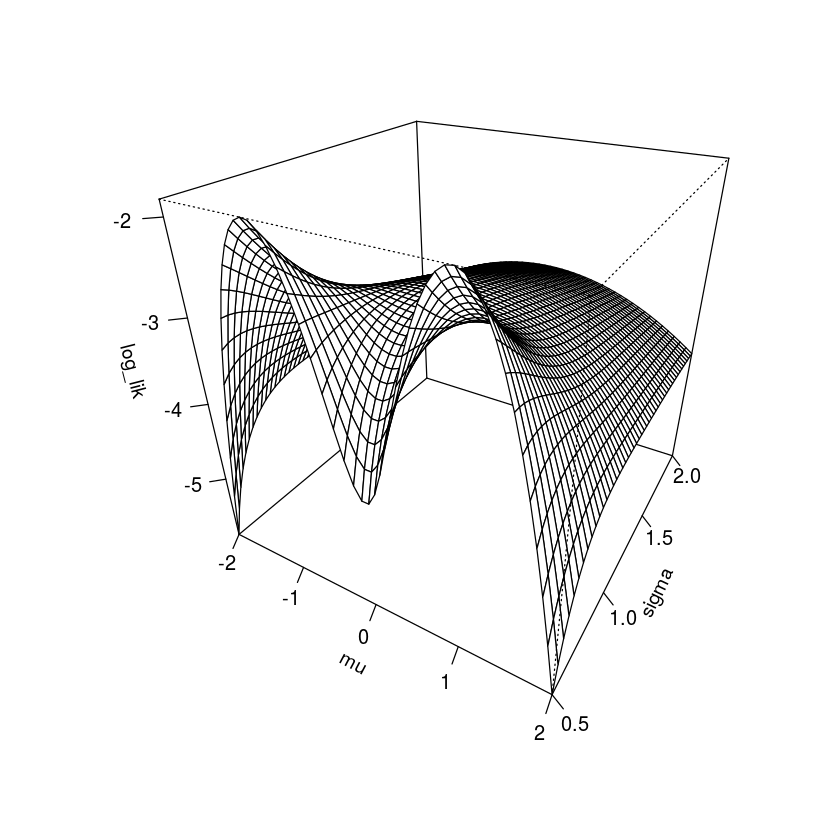

In [4]:
mu <- seq(-2,2,length.out=50)
sigma <- seq(0.5,2,length.out=50)
log_lik <- outer(mu,sigma,Vectorize(ll))
persp(mu, sigma, log_lik, theta=30, phi=30, ticktype="detailed")

At each fixed $\sigma$:
* The symmetry in $\mu$ comes from the fact that we can swap the clusters and get the same likelihood.
* There is an extremum at $\mu=0$,
  * which is a _local minimum_ for $\sigma < 1$ (so the clusters like to move apart)
  * but a _global maximum_ for $\sigma \geq 1$ (where the clusters like to move together).
  * These correspond to low and high temperature in deterministic annealing.
  * The phase shift happens at the "critical temperature" where $\sigma = 1$, probably because that's the _sample_ stdev.
  
We can see that transition by zooming in on $\sigma \approx 1$:

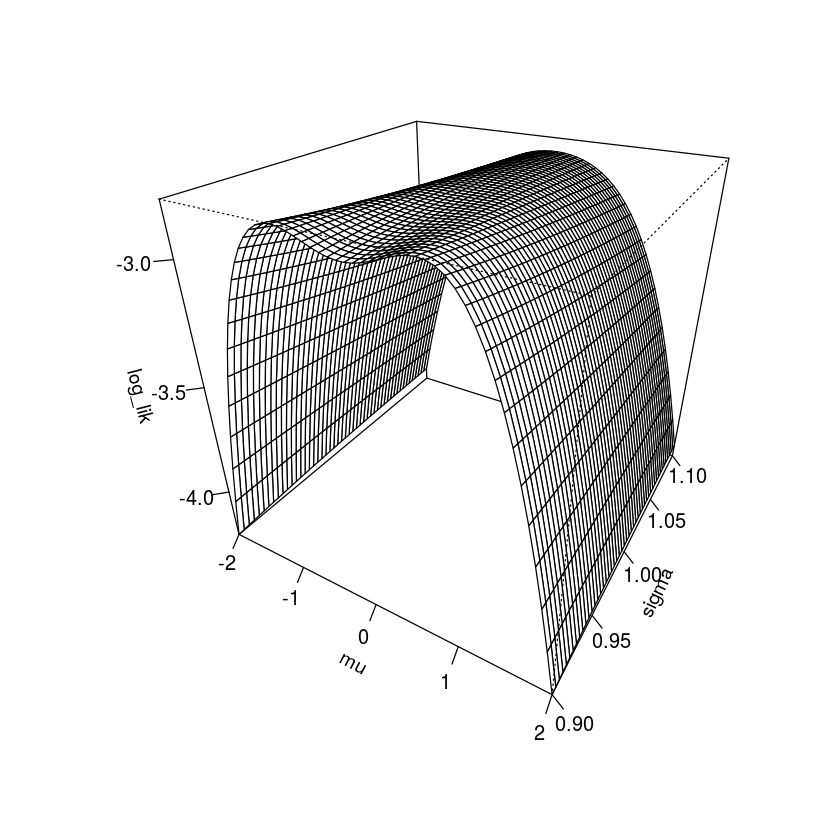

In [5]:
sigma <- seq(0.9,1.1,length.out=50)
log_lik <- outer(mu,sigma,Vectorize(ll))
persp(mu, sigma, log_lik, theta=30, phi=30, ticktype="detailed")

If we allow $\sigma$ to vary, however:

* The global maximum puts one cluster at each point, with $\sigma$ as small as possible.  (Actually there are two symmetric maxima of this sort.)
* So $\sigma$ _wants_ to become small, allowing the clusters to specialize.

# Alternating optimization

But when can we computationally find this maximum?  There are are no other local maxima on the whole surface.  But finding a global maximum might still be hard!  The problem is that $(\mu=0,\sigma=1)$ is a very stable and somewhat attractive saddle point.

Let's see what goes wrong in the case of alternating optimization.

First we hold $\sigma > 1$ fixed while optimizing $\mu$.  The argmax is $\mu=0$ (the Gaussian mixture becomes a single Gaussian):

In [6]:
library(repr)
options(repr.plot.width=3, repr.plot.height=3) # smaller plots

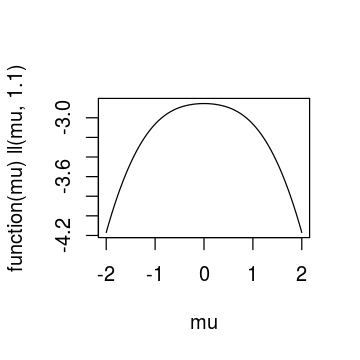

In [7]:
plot(function (mu) ll(mu,1.1), xlab="mu", xlim=c(-2,2))

Now we hold $\mu=0$ fixed while optimizing $\sigma$.  It moves to the sample stdev, namely 1.  (In fact, this is true regardless of where $\sigma$ starts.)

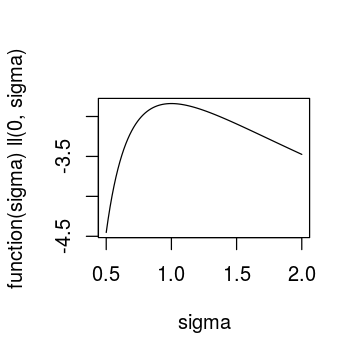

In [8]:
plot(function (sigma) ll(0,sigma), xlab="sigma", xlim=c(0.5, 2))

We're now stuck at this saddle point $(\mu,\sigma)=(0,1)$: for this $\sigma$, our current $\mu=0$ is already optimal.  

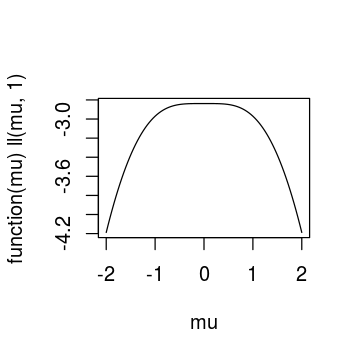

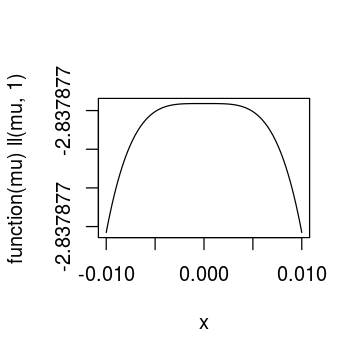

In [9]:
plot(function (mu) ll(mu,1), xlab="mu", xlim=c(-2,2))
plot(function (mu) ll(mu,1), xlim=c(-.01,.01))   # zooming in

# The Hessian
Pause for a moment to notice how flat the top of that graph is.  Not only is this a critical point, but the Hessian is singular, so if we start near the critical point, even a second-order optimizer will be slow to get away.  The Hessian is $\left( \begin{array}{cc}\frac{\partial^2}{\partial^2\mu} & \frac{\partial^2}{\partial\sigma\partial\mu} \\ \frac{\partial^2}{\partial\mu\partial\sigma} & \frac{\partial^2}{\partial^2\sigma}\end{array} \right)L = \left( \begin{array}{rr}0 & 0 \\ 0 & -4\end{array} \right)$:

In [10]:
library(numDeriv)
grad(function (x) ll(x[1],x[2]), c(0,1))     # numerical gradient
hessian(function (x) ll(x[1],x[2]), c(0,1))  # numerical Hessian
det(.Last.value)  # it's singular, obviously

[1]  0.000000e+00 -9.997098e-12

[,1]          [,2]        
[1,] -1.049523e-08 -2.64677e-09
[2,] -2.646770e-09 -4.00000e+00

[1] 4.198092e-08

This really is a saddle point, not a local maximum, since there are better points arbitrarily close by (to find one, we have to nudge $\mu$ more than $\sigma$):

In [11]:
ll(0.1,0.999) - ll(0,1)

[1] 1.311065e-06

In [12]:
ll(0.01,0.99999) - ll(0,1)

[1] 1.333111e-10

# Follow the gradient?
It seems that alternating optimization led us right into the maw of a pathological case.  Maybe gradient ascent will be better?  There's no hope if we start with $\mu=0$ exactly -- we can't break the symmetry and we'll immediately jump to the saddle point $(0,1)$ and stay there.  But as long as $\mu \neq 0$, we do prefer $\sigma < 1$.  So the hope is that as long as we start at $\mu \neq 0$, then we'll eventually get to $\sigma < 1$, at which point $\mu$ will want to move away from 0 to specialize the clusters.

More precisely, the optimal $\sigma \neq 1$ for any $\mu \neq 0$.  (You might expect that if $\mu=0.1$, then $\sigma=0.9$ so that the Gaussian at 0.1 can best explain the point at 1, but actually $\sigma > 0.9$ in this case so that it can help explain the point at -1 as well.)  

Here are the optimal $\sigma$ values for $\mu=.1, .4, .6, .8, 1$.  (The limiting case of $\mu=1$ is interesting because then the optimal clusters are Dirac deltas, i.e., $\sigma = 0$.  For $\mu > 1$, which isn't shown here, the optimal $\sigma$ grows again ... in fact without bound as $\mu \rightarrow \infty$.)

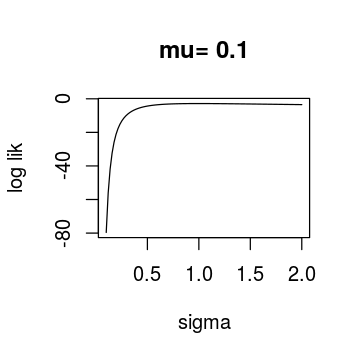

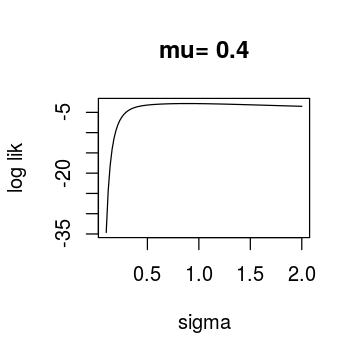

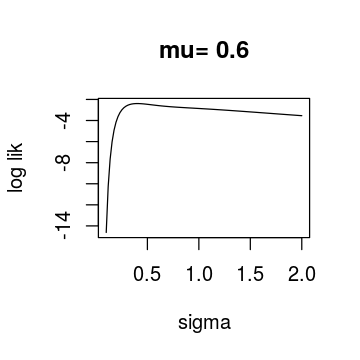

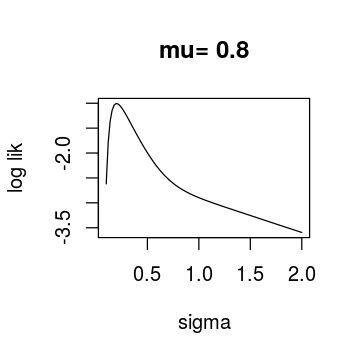

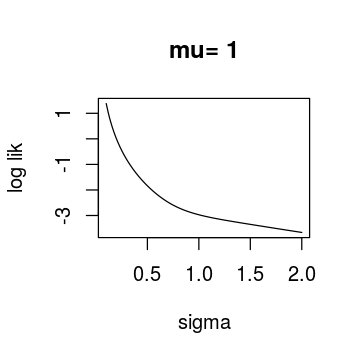

In [13]:
for (mu in c(.1,.4,.6,.8, 1)) plot(function (sigma) ll(mu,sigma), ylab="log lik", xlab="sigma", main=paste("mu=",mu), xlim=c(0.1,2))

Again, if we could keep $\mu \neq 0$ long enough to get to $\sigma < 1$, we'd be out of danger -- at least if $\sigma$ stayed $< 1$ -- since then the Gaussians would prefer to separate, leading us to the global max.  To see the separation, here's what $\mu$ prefers for $\sigma=0.9$:

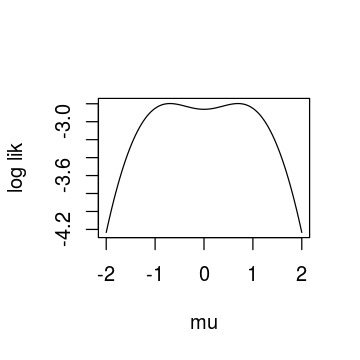

In [14]:
plot(function (mu) ll(mu,.9), ylab="log lik", xlim=c(-2,2), xlab="mu")

This doesn't guarantee that we'll be saved from the saddle point.  One might worry that if we start with $\sigma > 1$, which prefers $\mu = 0$, then $\mu$ might approach 0 so quickly that $\sigma$ doesn't have a chance to pull away from 0 and achieve "escape velocity."  However, the plots below seem to show that this problem does _not_ arise: $\sigma$ changes more quickly than $\mu$ if we follow the gradient.

In [15]:
options(repr.plot.width=7, repr.plot.height=7)

In [16]:
# Show the vector field of a function's gradients (in gray), 
# as well as some trajectories followed by gradient ascent (in dark green with green arrowheads).
# The function must be from R^2 -> R.
gradient_field <- function (fun,xlim,ylim,scale=0.1,nn=c(40,40),nntraj=c(7,7),eps=1e-6,iters=100,scaletraj=scale*20/iters) {
    # partial derivatives of fun (should probably use grad from numDeriv package instead, but that won't eval at many points in parallel)
    gradx <- function (x,y) (fun(x+eps,y)-fun(x-eps,y))/(2*eps)
    grady <- function (x,y) (fun(x,y+eps)-fun(x,y-eps))/(2*eps)
    # methods that will be used below to draw gradient steps
    drawfield     <- function (x0,y0,x1,y1) { suppressWarnings(arrows(x0,y0,x1,y1, length=0.05, angle=15, col="gray65")) }
    drawtraj      <- function (x0,y0,x1,y1) { segments(x0,y0,x1,y1, col="darkgreen") }   # line segments with no head
    drawtrajlast  <- function (x0,y0,x1,y1) { suppressWarnings(arrows(x0,y0,x1,y1, length=0.1, col="green")) }                                                      
    # grid of points    
    x <- seq(xlim[1],xlim[2],length.out=nn[1])
    y <- seq(ylim[1],ylim[2],length.out=nn[2])  
    xx <- outer(x,y, function (x,y) x)                                                         
    yy <- outer(x,y, function (x,y) y)     
    # draw the function using filled.contour, and imposed the arrows 
    filled.contour(x,y,fun(xx,yy),
                   plot.axes = {    # how to add to a filled.contour graph
                      axis(1); axis(2)    # label the axes
                      # draws a bunch of gradient steps in parallel starting at (xx,yy), and sets (newxx,newyy) to endpoints
                      segs <- function (xx,yy,scale,draw) { draw( xx, yy,
                                                newxx <<- xx + scale*gradx(xx,yy), 
                                                newyy <<- yy + scale*grady(xx,yy) ) }     
                      # vector field
                      segs(xx,yy, scale,drawfield)
                      # grid of points where we'll start trajectories 
                      seqmid <- function (lo,hi,len) { nudge <- (hi-lo)/(2*len); seq(lo+nudge,hi-nudge,length.out=len) }  # e.g., seqmid(0,1,5) gives 0.1,0.3,...,0.9, the same as the odd positions in seq(0,1,11)            
                      x <- seqmid(xlim[1],xlim[2],nntraj[1])
                      y <- seqmid(ylim[1],ylim[2],nntraj[2])
                      xx <- outer(x,y, function (x,y) x)                                                         
                      yy <- outer(x,y, function (x,y) y)  
                      # draw those trajectories
                      for (i in 1:iters) {
                          segs(xx,yy, scaletraj, if (i < iters) drawtraj else drawtrajlast)
                          done <- gradx(xx,yy)==0 & grady(xx,yy)==0      # which trajectories won't move any more?
                          xx <- ifelse(done, xx, newxx)  # update for next segment except where there wouldn't be a next segment
                          yy <- ifelse(done, yy, newyy) 
                      }
                      # hack for this application: plot markers at specific critical points
                      points( c(0,1,-1),c(1,0,0),col=2)    
                   })
}

<a name="gradient-field"></a>

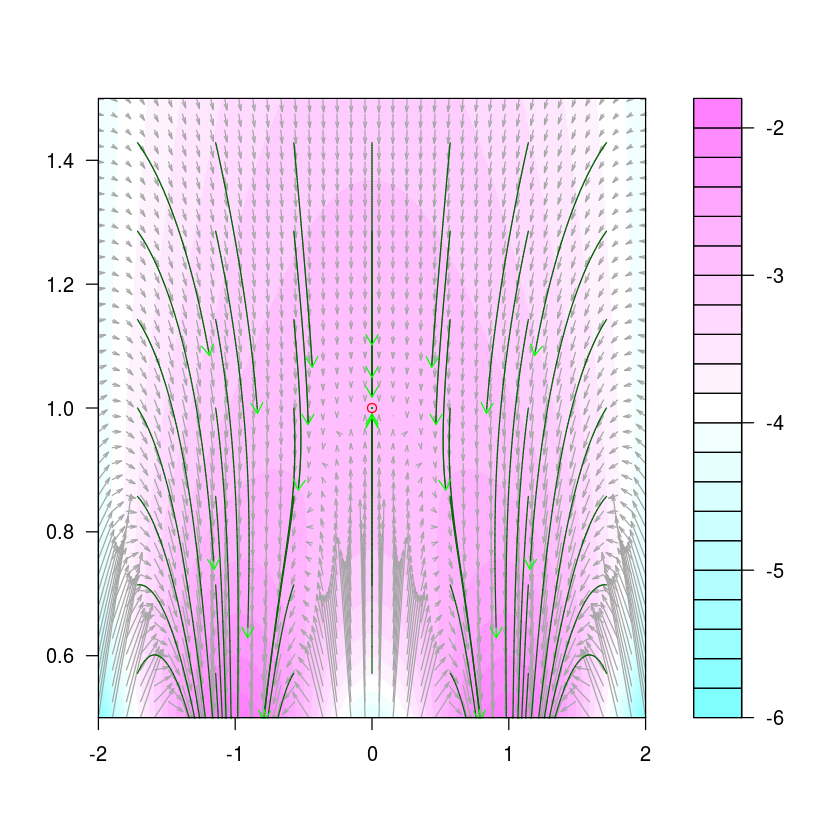

In [17]:
gradient_field(ll,c(-2,2),c(0.5,1.5), scale=0.03)                                

Zoomed in around saddle point:

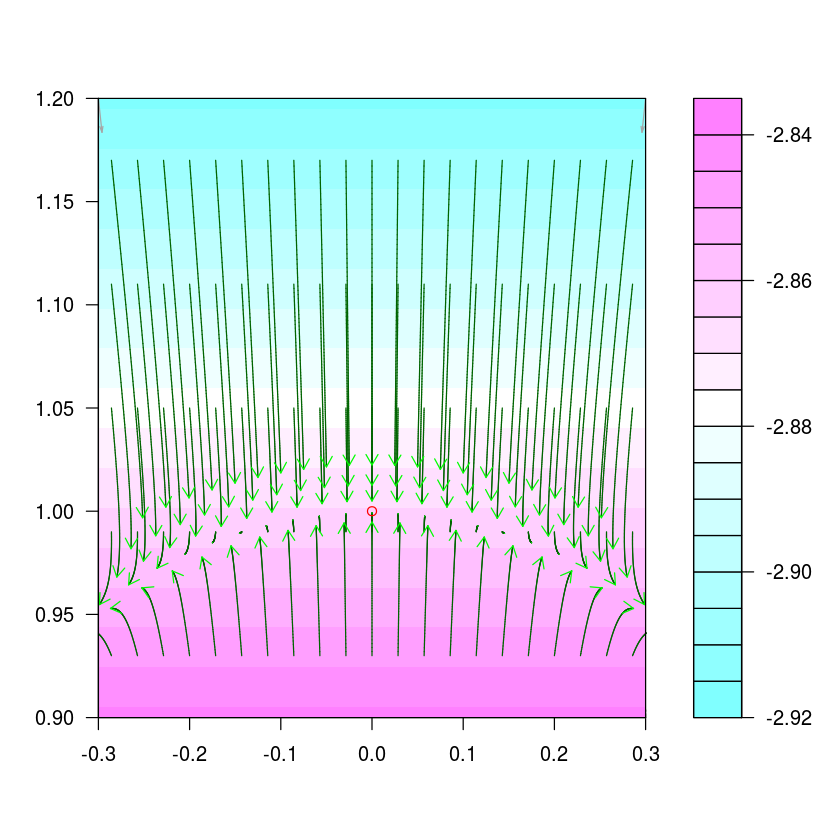

In [18]:
gradient_field(ll,c(-0.3,0.3),c(0.9,1.2), scale=0.03, nn=c(2,2), nntraj=c(21,5))

# Expectation Maximization
So far we've seen that alternating optimization hits the saddle point for many initializers, but gradient descent appears to evade the saddle point as long as it's initialized at $\mu \neq 0$.  

Now let's try EM, which is closely related to gradient descent but doesn't require a stepsize:

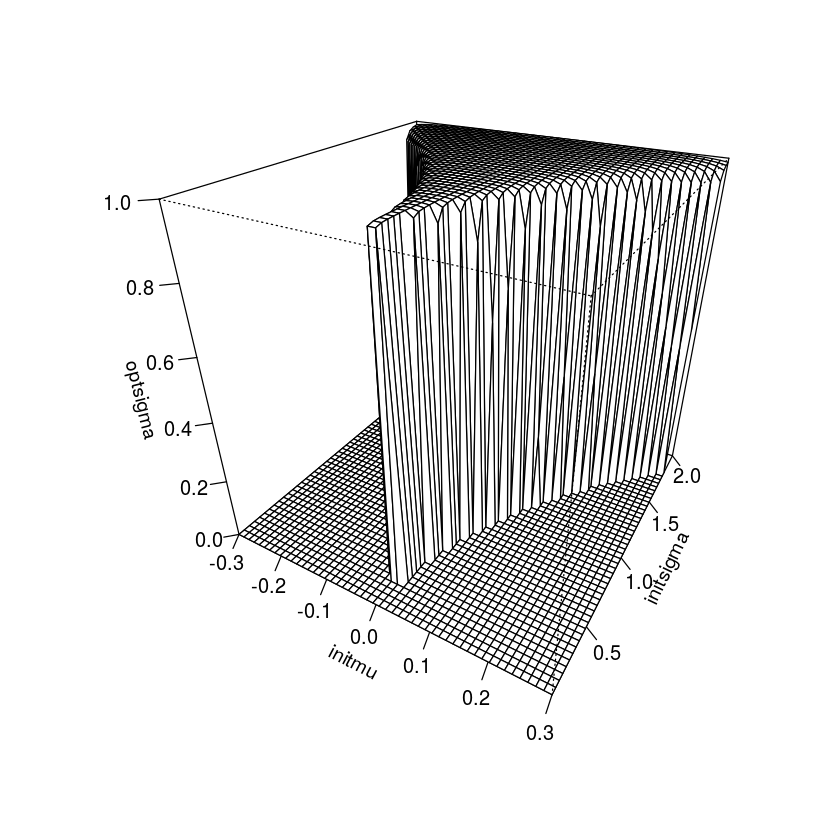

In [19]:
# probability that observed datapoint 1 comes from +mu cluster rather than -mu cluster
pEM <- function(mu,sigma) ifelse(sigma==0, 1,    # test avoids Inf/Inf
                                 dnorm(1,mu,pmax(0,sigma)) / ( dnorm(1,mu,pmax(0,sigma)) + dnorm(1,-mu,pmax(0,sigma)) )) 

# EM update rules
emUpdate <- function(ms) {  # pass in c(mu,sigma) as a pair
    p <- pEM(ms[1],ms[2])
    m <- 1*p + (-1)*(1-p)   # new mu is an average of the 1 and -1 datapoints with weights p and (symmetrically) 1-p
    s <- sqrt((1-m)**2 * p + (-1-m)**2 * (1-p))
    c(m,s)
}
# Iterate EM updates
emFinalSigma <- function(m,s, maxiters=100) { 
    ms <- c(m,s)
    for (i in seq_len(maxiters)) { new <- emUpdate(ms); if (identical(ms,new)) break; ms <- new }  # quit early upon numerical convergence
    ms[2]
}
initmu <- seq(-0.3,0.3,length.out=50)
initsigma <- seq(0.1,2,length.out=50)                             
optsigma <- outer(initmu,initsigma,Vectorize(emFinalSigma))
persp(initmu, initsigma, optsigma, theta=30, phi=30, zlim=c(0,1), ticktype="detailed")  

It looks above like for many initializers, EM actually gets it wrong and converges to the saddle point!
However, this is misleading -- it's really just that 100 iterations wasn't enough to escape the saddle point.
We have slow convergence to a global optimum, with a lot of time spent first near the saddle point.

If we changed the # of iterations above to only do 1 iteration, then we'd see that *most* starting values jump up to $\sigma \approx 1$.  But they don't get _quite_ to $\sigma=1$, so as we increase the number of iterations, it turns out that we _eventually_ find our way back to $\sigma = 0$.
Indeed, increasing to 1000 or 10000 iterations narrows the region of bad starting points.

So, let's graph how long it takes EM to converge numerically (apparently to 0) as a function of the initial $(\mu,\sigma)$ value:

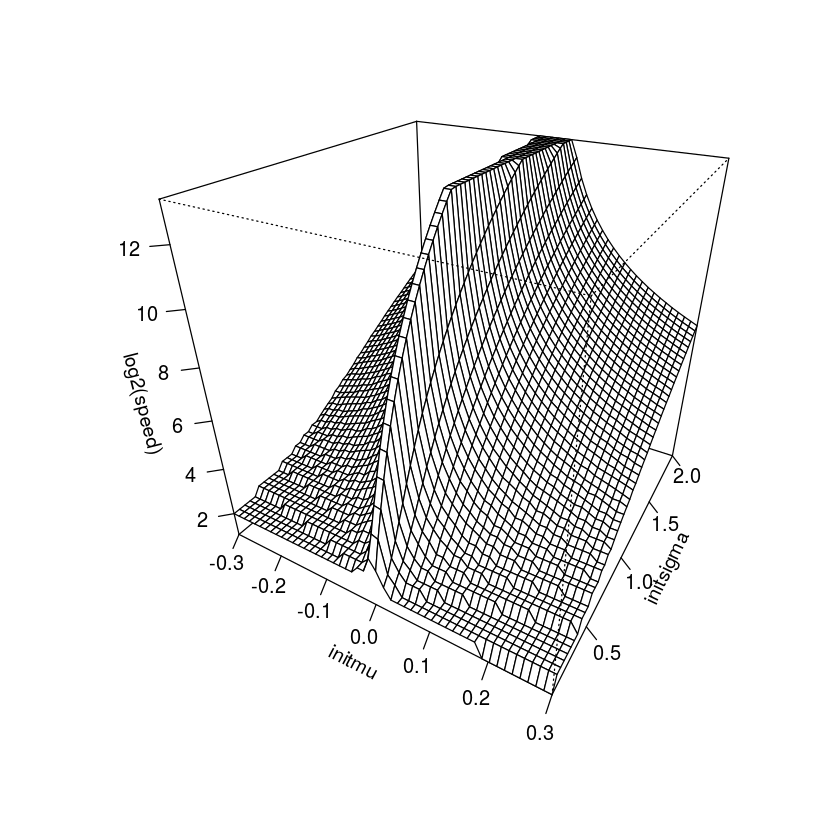

In [20]:
emSpeed <- function(m,s, maxiters=10000) { 
    ms <- c(m,s)
    for (i in seq_len(maxiters)) { new <- emUpdate(ms); if (identical(ms,new)) break; ms <- new }  # quit early upon numerical convergence
    i
}                             
speed <- outer(initmu,initsigma,Vectorize(emSpeed))
persp(initmu, initsigma, log2(speed), theta=30, phi=30, ticktype="detailed")  

For example, the part of that graph above $z=7$ represents the set of initial points for which after $2^{7} = 128$ iterations, EM still hasn't converged, and is usually still hanging out at $\sigma\approx 1$.

What's going on is that for small initial $\mu$, we find that $\sigma$ jumps up to just less than 1, and then -- very slowly -- $\mu$ creeps upward and $\sigma$ creeps downward from 1, until finally it accelerates and we get to the global optimum of $(1,0)$.  Let's see how $\mu$ (black) and $\sigma$ (red) change over time when we initialize EM at (0.02, 0.8):

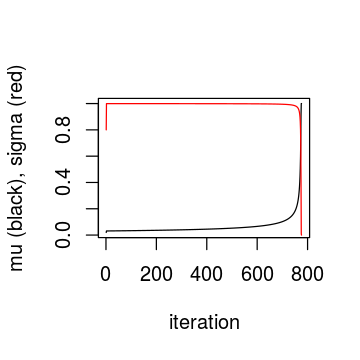

In [21]:
emTraj <- function(m,s, maxiters=10000) { 
    muTraj <- rep(NA,maxiters)
    sigmaTraj <- rep(NA,maxiters)
    ms <- c(m,s)
    for (i in seq_len(maxiters)) { new <- emUpdate(ms); if (identical(ms,new)) break; 
                                   ms <- new; muTraj[i] <- ms[1]; sigmaTraj[i] <- ms[2] }
    list(c(m,muTraj[1:i]), c(s,sigmaTraj[1:i]))
}                             
t <- emTraj(0.02,0.8)
options(repr.plot.width=3, repr.plot.height=3) # smaller plots
plot(t[[1]],type="l",xlab="iteration",ylab="mu (black), sigma (red)")
lines(t[[2]],type="l",xlab="iteration",col="red")
options(repr.plot.width=7, repr.plot.height=7) # restore old settings

Essentially, the problem is that [the likelihood surface shown earlier](#ll-surface) has a big trough in the front where the gradient points sharply up toward the saddle point.  (You can also see that in the [gradient vector field](#gradient-field).)  If we start in that trough, the EM optimizer will immediately catapult us up near the saddle point, which we then escape only slowly.  

Rephrasing this in terms of the GMM: if our initializer breaks symmetry only slightly, then we are initially trying to explain all the data with all the clusters, and we are slow to escape that.  If we want to quickly reach an asymmetric solution -- and we do! -- then we either need a more asymmetric initializer (e.g., we could choose actual datapoints as our centroids, with low variance) or a different optimizer.

# Other optimization methods
So, how about other *standard* optimization methods?  Their success depends on the initializer, much like running EM for only 1000 iterations.  Often they seem to converge numerically when $\sigma$ is still close to 1 but they haven't really converged.  Let's look at the optimal value of $\sigma$ as a function of the starting point of the optimizer.

In [22]:
o <- function (optmethod) 
        function (initmu,initsigma) 
           optim(c(initmu,initsigma), 
                 function (x) min(-ll(x[1],x[2]),1e9), method=optmethod)$par[2]
show <- function(optmethod) {
   optsigma <- outer(initmu,initsigma,Vectorize(o(optmethod)))  
   # filled.contour(initmu, initsigma, optsigma, zlim=c(0,1.2), xlab="initmu", ylab="initsigma")  # pink points (optsigma=1) are where we failed
   persp(initmu, initsigma, optsigma, theta=30, phi=30, zlim=c(0,1), ticktype="detailed")
   invisible(optsigma)  # return for subsequent analysis
}

L-BFGS-B likewise terminates near the saddle point if we initialize too close to the saddle point.

(It also seems to occasionally stop when $\sigma$ is between 0 and 1: must be
a flaky termination condition.)

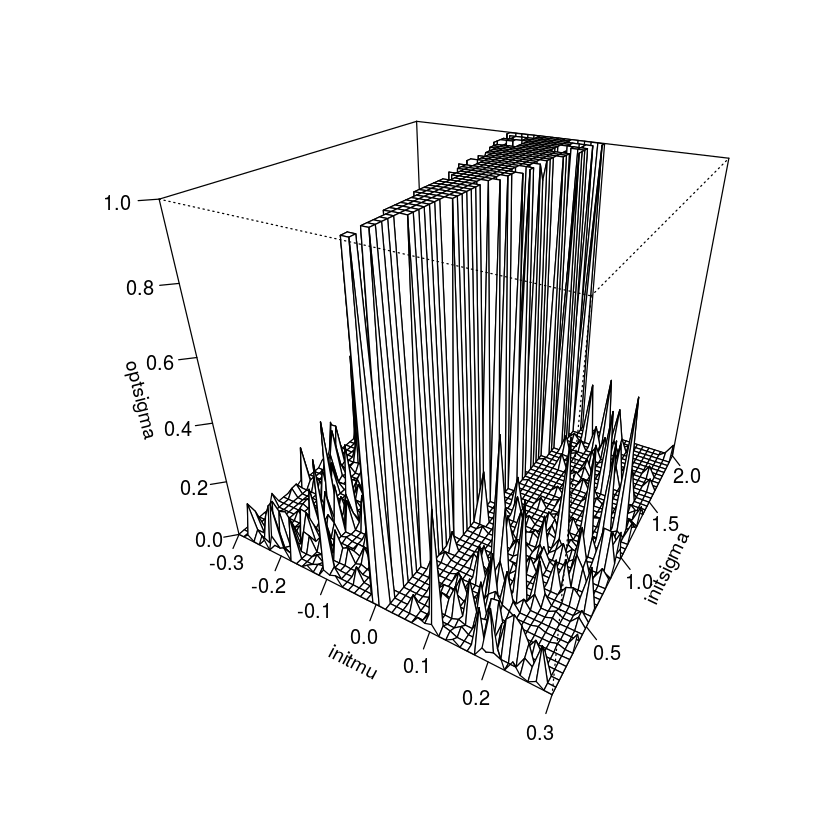

In [24]:
show("L-BFGS-B")

CG fails under the same circumstances (though without the flakiness).  
(Technical note: when it succeeds, it generally drives $\sigma$ negative rather than the desired 0, but that's an illegal value; we allow it only for convenience, because we defined ll to round $\sigma<0$ up to 0.)

Warning message in persp.default(initmu, initsigma, optsigma, theta = 30, phi = 30, :
“surface extends beyond the box”

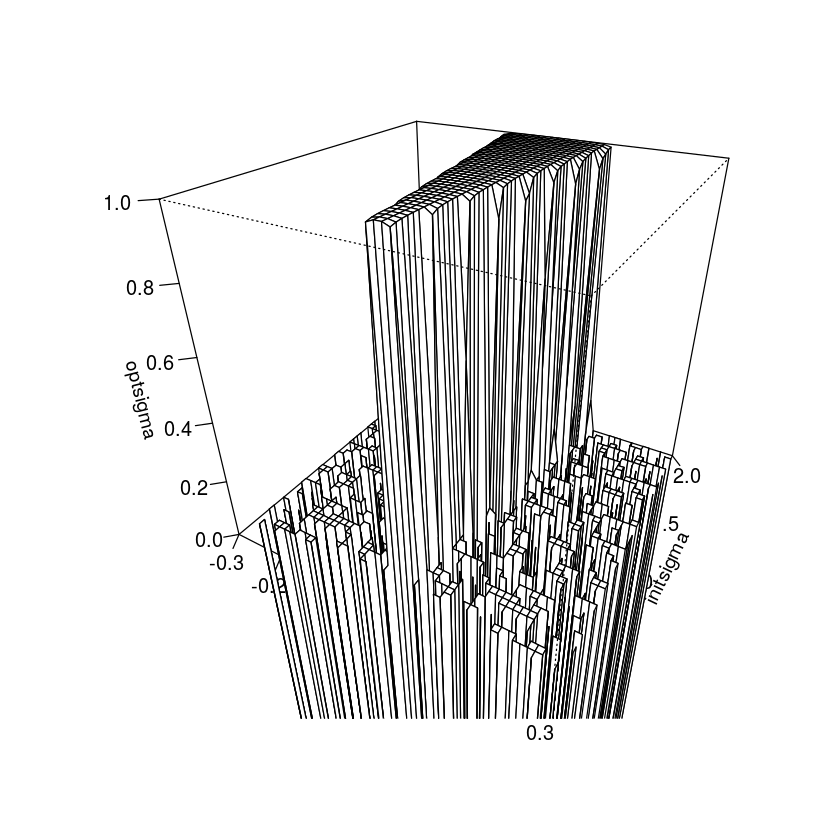

In [25]:
show("CG")

BFGS fails under the same circumstances (with a little flakiness).

Warning message in persp.default(initmu, initsigma, optsigma, theta = 30, phi = 30, :
“surface extends beyond the box”

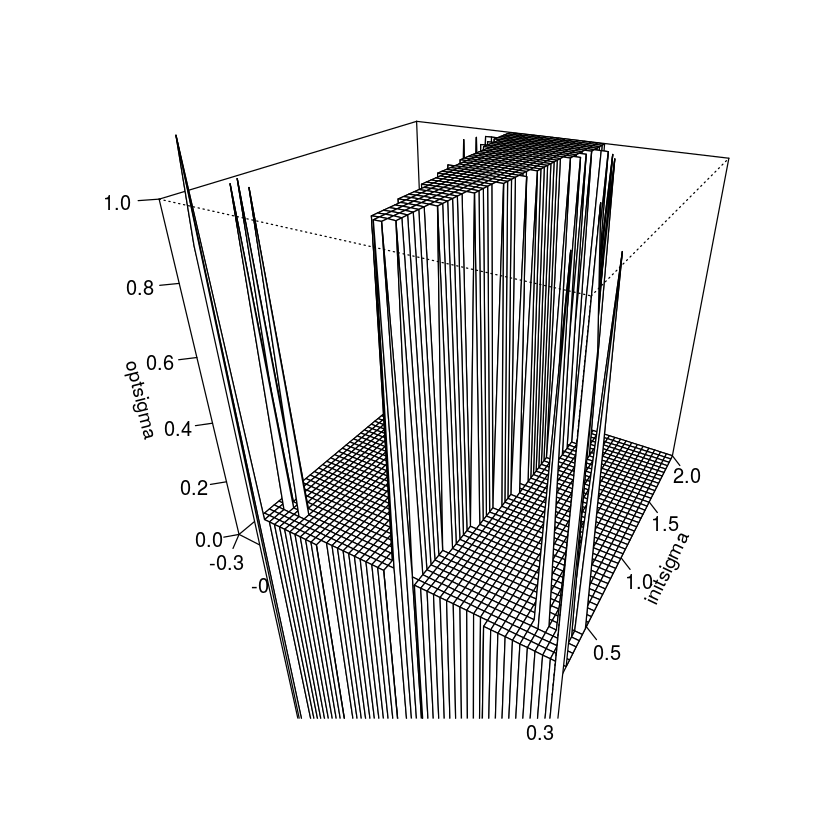

In [26]:
show("BFGS")

Nelder-Mead doesn't use the gradient and nearly always succeeds!

Warning message in persp.default(initmu, initsigma, optsigma, theta = 30, phi = 30, :
“surface extends beyond the box”

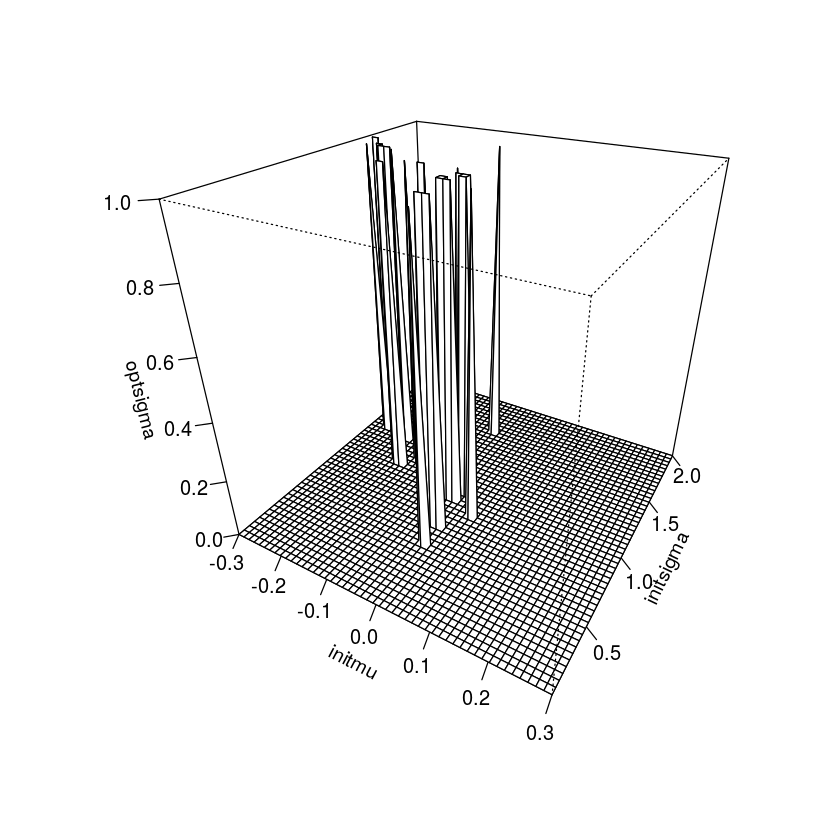

In [27]:
show("Nelder-Mead")

Simulated annealing is very slow.  The perspective plot looks crazy ...

Warning message in persp.default(initmu, initsigma, optsigma, theta = 30, phi = 30, :
“surface extends beyond the box”

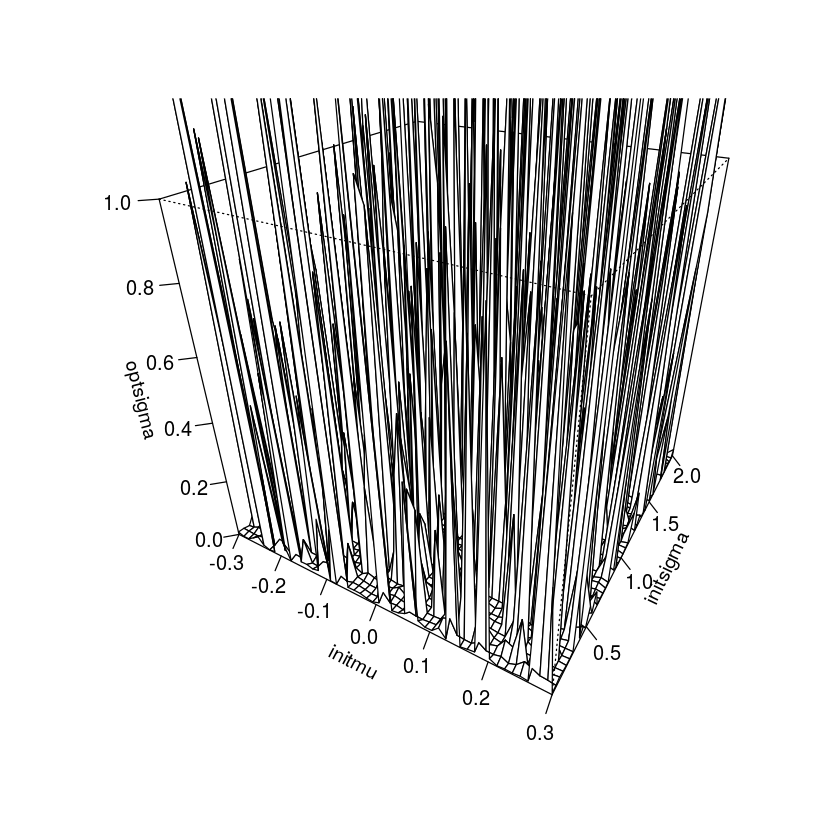

In [28]:
optsigma <- show("SANN")

... but actually, simulated annealing usually gets the right answer, 
only occasionally finding $\sigma$ values greater than about 0 (although those go up to 3):

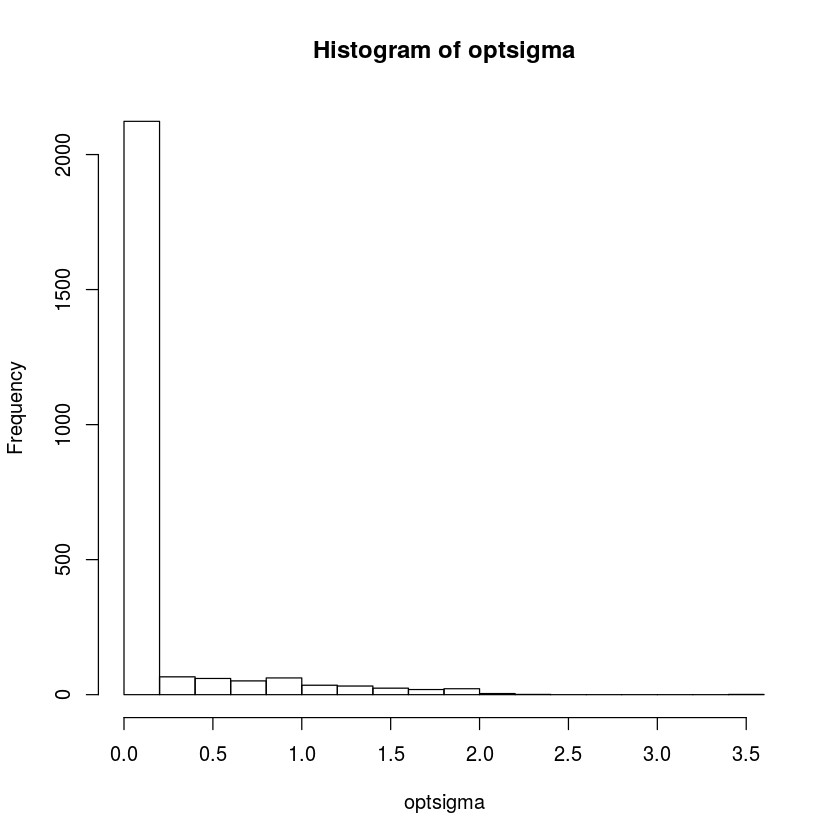

In [29]:
hist(optsigma)

The reason that the perspective plot looks funny is that it's a randomized method that
is not very sensitive to initial condition, so the mistakes are all over the place:

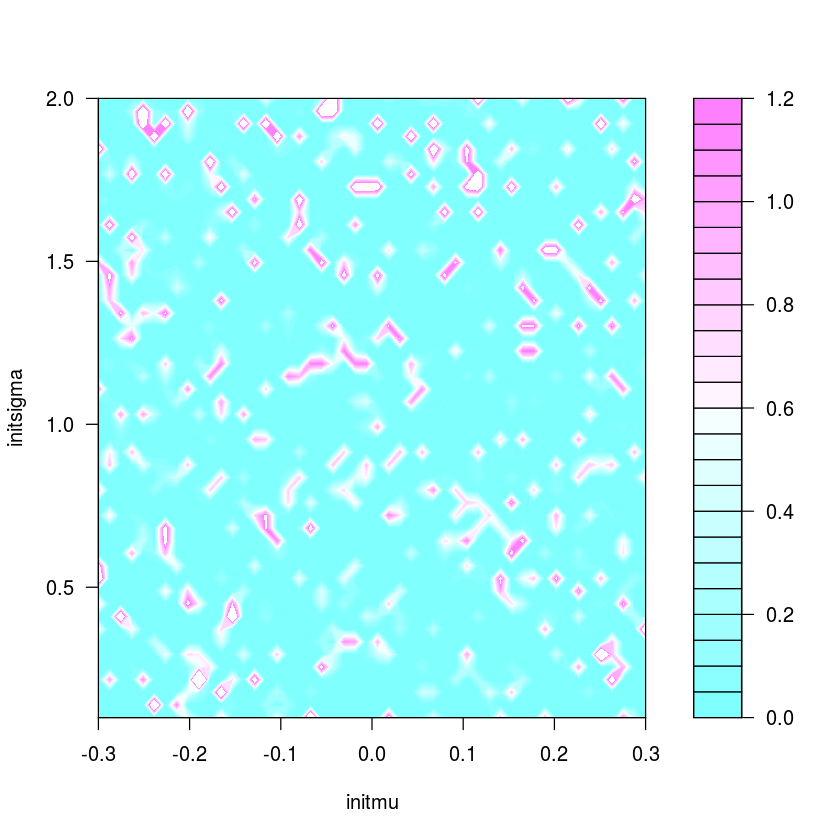

In [30]:
filled.contour(initmu, initsigma, optsigma, xlab="initmu", ylab="initsigma",zlim=c(0,1.2))

Interestingly, it does turn out that if $\sigma$ starts out greater than 1, simulated annealing always figures out to decrease it, whereas if $\sigma$ starts out less than 1, sometimes it increases:

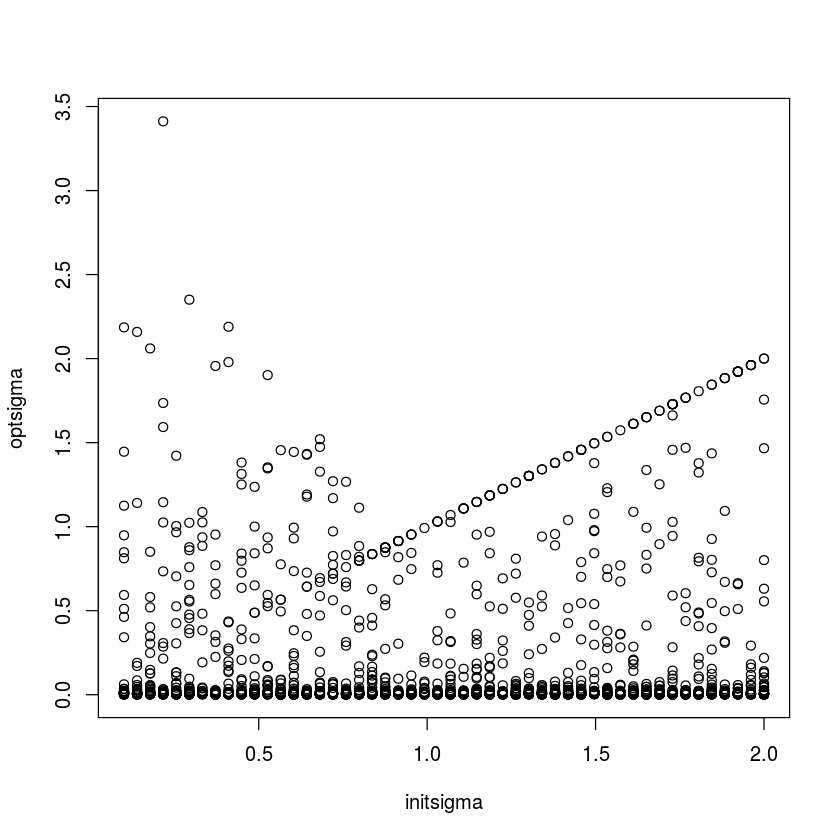

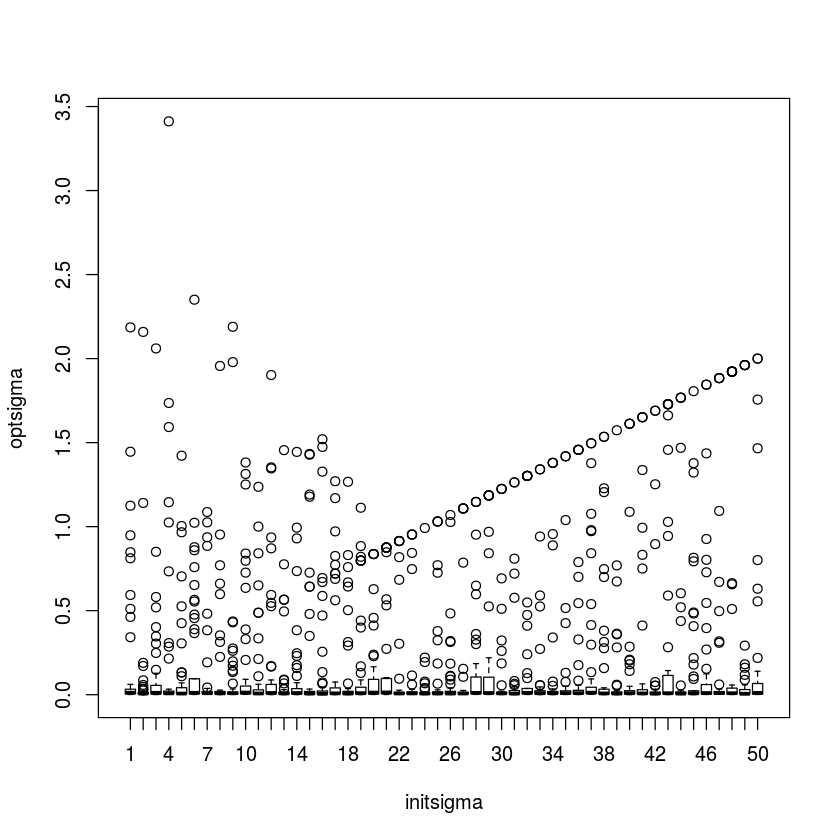

In [31]:
plot(rep(initsigma,length(initmu)),t(optsigma),xlab="initsigma",ylab="optsigma")
boxplot(optsigma,xlab="initsigma",ylab="optsigma")  # same thing with boxplot+outliers

**TODO:** Try stochastic GD.  We only have 2 datapoints, so this would be done as batch GD with a little noise added to each step.

# Takeaway
In general, one possible solution to the slow convergence difficulty is not to optimize $\sigma$ using its gradient, but rather to sweep through the $\sigma$ values as an outer loop for optimization.  

Deterministic annealing (DA) is one such scheme, and it may have the additional advantage that it heuristically helps find a better local optimum in problems with non-equivalent local optima.  DA gradually decreases $\sigma$, initializing the $\mu$ optimization for each $\sigma$ at the (perturbed) argmax of the previous (slightly larger) $\sigma$. High $\sigma$ has a single global optimum, which splits and then splits further as we pass through critical temperatures, until all of the clusters are distinct.  We have to perturb $\mu$ in order to break symmetry  -- in the above example, $\mu=0$ for $\sigma \geq 1$, so we have to push it slightly away from 0 each time.  As $\sigma$ becomes $< 1$, then $\mu$ will no longer snap back to 0 but will start to specialize by moving a little bit away from 0.  If $\mu$ were high-dimensional, the direction of the random perturbation could affect exactly how the clusters specialize, i.e., it will end up influencing which local optimum we find, although of course this is also affected by the data through the gradient.